In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Loading Data
labels_names =['Stadium','Building','Traffic Sign','Forest','Flowers',
              'Street','Classroom','Bridge','Statue','Lake']
data_train = np.load('data_train.npy')
labels_train = np.load('labels_train.npy')
labels_train = labels_train.astype(int)
class_labels, _ = np.unique(labels_train, return_counts=True)

In [3]:
from PIL import Image
import os
import errno
#Converting data to directory
transposed_data = data_train.T

for idx, l in np.ndenumerate(labels_train):
   # data = data_train[:,idx]
    data = transposed_data[idx]
    img = Image.fromarray( data.reshape((300,300,3)), 'RGB')
    horz_img = img.transpose(method=Image.FLIP_LEFT_RIGHT)
    labelNr = l - 1
    filename = f'KerasPrep/{labelNr}/{idx[0]}.jpg'
    filename2 = f'KerasPrep/{labelNr}/{idx[0]}flip.jpg'
    if not os.path.exists(os.path.dirname(filename)):
        try:
            os.makedirs(os.path.dirname(filename))
        except OSError as exc: # Guard against race condition
            if exc.errno != errno.EEXIST:
                raise
    img.save(filename)
    horz_img.save(filename2)

In [2]:
from tensorflow.keras.applications import ResNet50
def build_retrained_model(batch_size, img_height, img_width, data_dir, validation_split,random_rotation,random_zoom,dropout,base_learning_rate):
    # dividing in classes train and validation
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
      data_dir,
      validation_split=validation_split,
      subset="training",
      seed=123,
      image_size=(img_height, img_width),
      batch_size=batch_size)

    num_classes = len(train_ds.class_names)

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
      data_dir,
      validation_split=validation_split,
      subset="validation",
      seed=123,
      image_size=(img_height, img_width),
      batch_size=batch_size)
    
    AUTOTUNE = tf.data.AUTOTUNE

    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
    
     #flip the images and rotate and zoom to increase generalization.
    data_augmentation = keras.Sequential(
      [
        layers.RandomFlip("horizontal",
                          input_shape=(img_height,
                                      img_width,
                                      3)),
        layers.RandomContrast(0.2),
        layers.RandomRotation(random_rotation),
        layers.RandomZoom(random_zoom),
        layers.Rescaling(1./255),
      ]
    )
    # build model with ResNet50
    model = Sequential([
        data_augmentation,
      ResNet50(include_top=False, weights='imagenet', pooling='max'),
        layers.Flatten(),
      layers.Dense(1028, activation='relu'),
      layers.Dropout(dropout),
      layers.Dense(num_classes)
    ])
    
    return model, train_ds, val_ds

In [3]:
# Parameters for the Model
batch_size = 32
img_height = 224
img_width = 224
data_dir = 'KerasPrep'
validation_split = 0.2
random_rotation = 0.35
random_zoom = 0.35
dropout = 0.24
epochs=10
base_learning_rate = 0.0001
IMG_SHAPE = (224, 224) + (3,)


# build base model
retrained_model, train_ds, val_ds = build_retrained_model(batch_size, img_height, img_width, data_dir, 
                                             validation_split,random_rotation,random_zoom,
                                             dropout,base_learning_rate)
# use adam model optimizer.
retrained_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
retrained_model.summary()
#train model
history = retrained_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)
    
retrained_model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
total_epochs =  epochs + 30

history_fine = retrained_model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)


Found 6248 files belonging to 10 classes.
Using 4999 files for training.


2021-12-10 22:25:56.887842: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-10 22:25:57.949499: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79124 MB memory:  -> device: 0, name: A100-SXM-80GB, pci bus id: 0000:87:00.0, compute capability: 8.0
2021-12-10 22:25:57.952928: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 79124 MB memory:  -> device: 1, name: A100-SXM-80GB, pci bus id: 0000:90:00.0, compute capability: 8.0


Found 6248 files belonging to 10 classes.
Using 1249 files for validation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1028)              2106372   
_________________________________________________________________
dropout (Dropout)            (None, 1028)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                10290     
Total params: 25,704,374
Trainable params: 25

2021-12-10 22:26:04.566916: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-10 22:26:15.692380: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201
2021-12-10 22:26:17.101911: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Running ptxas --version returned 32512
2021-12-10 22:26:17.235837: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 32512, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2021-12-10 22:26:19.817173: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


157/157 [==============================] - 40s 112ms/step - loss: 2.5459 - accuracy: 0.6663 - val_loss: 9.7003 - val_accuracy: 0.1065
Epoch 2/10
157/157 [==============================] - 11s 69ms/step - loss: 0.7239 - accuracy: 0.8382 - val_loss: 4.9958 - val_accuracy: 0.1249
Epoch 3/10
157/157 [==============================] - 11s 69ms/step - loss: 0.4342 - accuracy: 0.8894 - val_loss: 3.9529 - val_accuracy: 0.2362
Epoch 4/10
157/157 [==============================] - 11s 68ms/step - loss: 0.3644 - accuracy: 0.9086 - val_loss: 11.2240 - val_accuracy: 0.3347
Epoch 5/10
157/157 [==============================] - 11s 69ms/step - loss: 0.2851 - accuracy: 0.9294 - val_loss: 2.7237 - val_accuracy: 0.6533
Epoch 6/10
157/157 [==============================] - 11s 71ms/step - loss: 0.2286 - accuracy: 0.9348 - val_loss: 0.7405 - val_accuracy: 0.8567
Epoch 7/10
157/157 [==============================] - 11s 68ms/step - loss: 0.2279 - accuracy: 0.9456 - val_loss: 0.2769 - val_accuracy: 0.9343
E

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

acc_fine = history_fine.history['accuracy']
val_acc_fine = history_fine.history['val_accuracy']

loss_fine = history_fine.history['loss']
val_loss_fine = history_fine.history['val_loss']

epochs_range = range(total_epochs + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc + acc_fine, label='Training Accuracy')
plt.plot(epochs_range, val_acc + val_acc_fine, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss + loss_fine, label='Training Loss')
plt.plot(epochs_range, val_loss + val_loss_fine, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



In [11]:
# Test classification by downloading an image from the internet and then prediciting the class label (int value)

sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = retrained_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_labels[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to 5 with a 100.00 percent confidence.


In [71]:
def build_custom_model(batch_size, img_height, img_width, data_dir, validation_split,random_rotation,random_zoom,dropout,dropout2,number_of_layers,batch_normalization,start_neurons):
    # dividing in classes train and validation
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
      data_dir,
      validation_split=validation_split,
      subset="training",
      seed=123,
      image_size=(img_height, img_width),
      batch_size=batch_size)

    num_classes = len(train_ds.class_names)

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
      data_dir,
      validation_split=validation_split,
      subset="validation",
      seed=123,
      image_size=(img_height, img_width),
      batch_size=batch_size)

    AUTOTUNE = tf.data.AUTOTUNE

    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

    #flip the images and rotate and zoom to increase generalization.
    data_augmentation = keras.Sequential(
      [
        layers.RandomFlip("horizontal",
                          input_shape=(img_height,
                                      img_width,
                                      3)),
        layers.RandomContrast(0.2),
        layers.RandomRotation(random_rotation),
        layers.RandomZoom(random_zoom),
        layers.Rescaling(1./255),
      ]
    )
    # Building the sequential model with relu acitivation function
    
    main_model = []
    
    for layer in range((number_of_layers)):
        main_model += [layers.Conv2D((start_neurons * (2**layer)), 3, padding='same', activation='relu'),
                       layers.MaxPooling2D(2),
                       layers.Dropout(dropout)]
        
        if batch_normalization:
            main_model.append(layers.BatchNormalization())
    
    model = Sequential([
      data_augmentation,
        
        keras.Sequential(main_model),
        
      layers.Flatten(),
      layers.Dense((start_neurons * (2**(number_of_layers-1))), activation='relu'),
      layers.Dropout(dropout2),
      layers.Dense(num_classes)
    ])
    
    # use adam model optimizer.
   
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    """
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=[keras.metrics.TopKCategoricalAccuracy(k=3, name='acc_top3'),
                       keras.metrics.TopKCategoricalAccuracy(k=1, name='acc_top1')])
    """

    model.summary()
    return model, train_ds, val_ds

Found 6248 files belonging to 10 classes.
Using 4999 files for training.
Found 6248 files belonging to 10 classes.
Using 1249 files for validation.
Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_40 (Sequential)   (None, 300, 300, 3)       0         
_________________________________________________________________
sequential_41 (Sequential)   (None, 75, 75, 256)       298752    
_________________________________________________________________
flatten_18 (Flatten)         (None, 1440000)           0         
_________________________________________________________________
dense_38 (Dense)             (None, 256)               368640256 
_________________________________________________________________
dropout_27 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 1

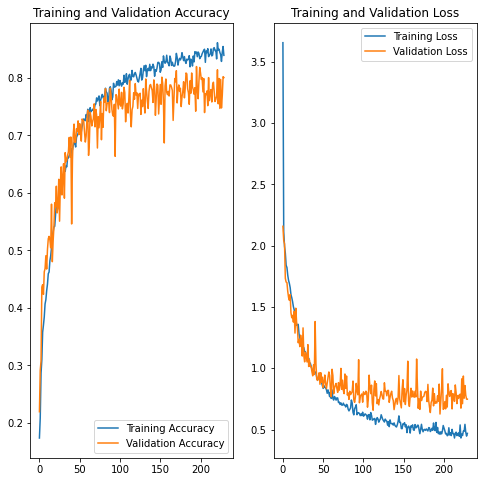

In [72]:
# Parameters for the Model
batch_size = 32
img_height = 300
img_width = 300
data_dir = 'KerasPrep'
validation_split = 0.2
random_rotation = 0.35
random_zoom = 0.35
dropout = 0.3
dropout2 = 0.31
start_neurons = 128
number_of_layers = 2
batch_normalization = False
epochs=230

# build model
custom_model, train_ds, val_ds = build_custom_model(batch_size, img_height, img_width, data_dir, 
                                             validation_split,random_rotation,random_zoom,
                                             dropout,dropout2,number_of_layers,batch_normalization,
                                             start_neurons)

#train model
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', min_delta=0.001, patience=6, verbose=0, mode='max',
    baseline=None, restore_best_weights=True
)


history = custom_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  #callbacks = [callback]
)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Test classification by downloading an image from the internet and then prediciting the class label (int value)

sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = custom_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_labels[np.argmax(score)], 100 * np.max(score))
)